# ORIE 5355/INFO 5370 HW 2: Recommendation systems

 - Name: Martin Sun
 - Net-id: ms2923
 - Date: 2021-10-2
 - Late days used for this assignment:
 - Total late days used (counting this assignment): 1
 - People with whom you discussed this assignment: 

After you finish the homework, please complete the following (short, anonymous) post-homework survey: https://forms.gle/5AG69LXM4yV3TL7o6 and include the survey completion code below.

### Question 0 [2 points]
<font color='blue'> Survey completion code: 

We have marked questions in <font color='blue'> blue </font>. Please put answers in black (do not change colors). You'll want to write text answers in "markdown" mode instead of code. In Jupyter notebook, you can go to Cell > Cell Type > Markdown, from the menu. Please carefully read the late days policy and grading procedure [here](https://orie5355.github.io/Fall_2021/assignments/). 

# Conceptual component

Go through the "Algorithms tour" [here](https://algorithms-tour.stitchfix.com/). It's a great view of the combination of algorithms used by a modern e-commerce company. 

<font color='blue'> 1) How do they use a combination of "latent" factors and explicit features to gain the benefits of collaborative filtering (matrix factorization) while not being susceptible to cold start issues?

StitchFix starts with a Style Profile for every customer.
Warehouse assignment using cost optimization.
Evaluate likelihood of liking item
    Tag item with multiple scores from different algorithms, ranked
    Collaborative filtering - people who liked similar things also liked other things to fill in sparse matrix
Cold start combated
    Lots of explicit data
        Client preferences
        Clothing attributes
    Mixed effects modeling. Tracks client preferences over time.
Latent features?
    Unstated features. Can infer from other data.
    Then further learn latent features through feedback and history.
Other client data is further used.
    Look at client Pinterest.
        Neural networks to vector classify similar items
    NLP to process textual information
Multiple algorithm scores all accounted for

StitchFix starts with a Style Profile that new customers must complete. This provides an excellent starting point
of explicit user data. Their inventory is also comprehensively described with clothing attributes. This is explicit
data, in combination with traditional collaborative filtering, is used to "learn" missing data from the matrix
factorization cold-start. One method is mixed-effects-modeling, which combines fixed and random effects to learn
client preferences over time. Latent features are further inferred from continuously updated client data and are used
in combination with explicit client data to further improve the recommendation model by filling in. Some ways StitchFix does this
include image recognition and NLP.

<font color='blue'> 2) How do they match clients with human stylists who make the final decision? Does it remind you of anything we learned in class?

Available stylists receive match scores to clients based on a number of data sets, including historical feedback and style
profiles. Very similarly to matching clients with warehouses or items, a matrix can be formed of these match scores and
optimized globally. The difference however, is that this is a two-sided-marketplace, combined with capacity constraints,
as discussed in class. The stylist must select a client and the applicable tasks to perform. In this way, not only does
each client get matched to suitable stylists, but every stylist must manually select their clients.

<font color='blue'> 3) How do they manage their inventory to ensure that they have enough items that future customers will want?

Algorithms are used to estimate future demand and appropriately allocate inventory to various warehouses.
StitchFix uses Markov Chains to forecast demand accurately. A model of the system dynamics are built and fitted with
historical data to forecast inventory requirements. Uncertainties are quantified and inputted to improve the reliability
of supply.

# Programming component

## Helper code

In [641]:
import numpy as np
import pandas as pd
import os, sys, math
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_theme()

def load_pickle(filename):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data

def load_ratings_and_factors(type_name = 'interaction'):
    ratings = load_pickle('data/{}_ratings'.format(type_name))
    book_vectors = load_pickle('data/{}_dict_book_factor'.format(type_name))
    user_vectors = load_pickle('data/{}_dict_reader_factor'.format(type_name))
    return ratings, book_vectors, user_vectors

In this homework, we are giving you trained user and book item vectors using a GoodReads dataset. Goodreads is a social cataloging website that allows individuals to search its database of books, annotations, quotes, and reviews. There are multiple types of interactions that a user can have with a book: add books to a list of books they intend to read ("short-list" the book), indicate they have read books before, and review books they have read. 

Here, we work with multiple types of interactions as training data for a recommendation system. For each "type" of rating data, we give you the raw ratings data, as well as user and item vectors trained using a Python package (https://berkeley-reclab.github.io/) that implements matrix factorization in cases where there are missing entries in a matrix. The "ratings" data is in a "sparse matrix"/dictionary format, meaning that the dictionary keys are of the kind (user, item), and the dictionary value is the corresponding value. Not all pairs are in the matrix, indicating that that value is missing or at its default value. 

There are 4 types of rating/interaction data:

 - `Interaction`: a "1" indicates the user has interacted with the book at some point in the past, either by saying that they intend to read it, have read it, or have given it a rating. If it is missing, that means the user has not interacted with the book.
 
 - `Explicit Rating`: explicit ratings. Numeric values indicate the ratings given. If it is missing, that means the user has not rated the book.
  
 - `Rating_all_zero`: explicit ratings. Numeric values more than 0 indicate the ratings given. Now, we replace missing values from above with "zeros," so that there are no missing ratings.
 
 - `Rating_interaction_zero`: explicit ratings. Numeric values more than 0 indicate the ratings given. Now, we replace missing values from above with "zeros," only if the user interacted with that book in the past.

In [642]:
ratings_interactions, book_vectors_interactions, user_vectors_interactions = load_ratings_and_factors(type_name = 'interaction')
ratings_explicit, book_vectors_explicit, user_vectors_explicit = load_ratings_and_factors(type_name = 'rating')
ratings_allmissing0, book_vectors_allmissing0, user_vectors_allmissing0 = load_ratings_and_factors(type_name = 'rating_all_zero')
ratings_interact0, book_vectors_interact0, user_vectors_interact0 = load_ratings_and_factors(type_name = 'rating_interaction_zero')


In [643]:
def get_shapes_and_ranges(ratings, book_vectors, item_vectors):
    print(len(ratings), np.shape(book_vectors), np.shape(item_vectors), min(ratings.values()), max(ratings.values()))

In [644]:
get_shapes_and_ranges(ratings_interactions, book_vectors_interactions, user_vectors_interactions)
get_shapes_and_ranges(ratings_explicit, book_vectors_explicit, user_vectors_explicit)
get_shapes_and_ranges(ratings_allmissing0, book_vectors_allmissing0, user_vectors_allmissing0)
get_shapes_and_ranges(ratings_interact0, book_vectors_interact0, user_vectors_interact0)

12238 (200, 10) (1000, 10) 1 1
8324 (200, 10) (1000, 10) 1 5
200000 (200, 10) (1000, 10) 0 5
12238 (200, 10) (1000, 10) 0 5


## Problem 1: Predictions and recommendations with different data types

### 1a) What do different data types mean?

<font color='blue'> What is `Rating_interaction_zero` trying to capture -- why would we fill in books that someone interacted with but did not rate as a 0? (Hint: connect to conceptual reading from HW1). Answer in no more than 3 sentences.

Determining which readers actually interacted with a book is critical to determining the true, underlying meaning of a rating.
By tracking the unrated interactions of a book, we may begin to analyze the unobservable quality, as it is likely that
many readers whose experience is bad or mediocre do not rate proactively. It is thus useful to know the propensity of positive
feedback out of all interactions.

<font color='blue'> What are some potential problems you see with using `rating_all_zero` for recommendations? Answer in no more than 3 sentences.
    
    

As mentioned before, this data set does not have any information of interaction, only ratings and non-ratings.
We do not know if someone didn't rate because the book was unremarkable or whether they did not read the book. We need
this critical information to make properly informed recommendations.

### 1b) Generating predictions

<font color='blue'> Fill in the following function that takes in a user matrix (where each row is 1 user vector) and an item matrix (where each row is 1 item vector), and returns a matrix of predicted ratings for each user and item, where each entry is associated with the corresponding user (row number) and item (column number)

In [645]:
def get_predictions(user_vectors, book_vectors):
    return np.matmul(user_vectors,book_vectors.T)

<font color='blue'> Output the predictions for first 10 items for the first user, using each of the 4 data types

In [646]:
exp_pred = get_predictions(user_vectors_explicit, book_vectors_explicit)
exp0_pred = get_predictions(user_vectors_allmissing0, book_vectors_allmissing0)
int_pred = get_predictions(user_vectors_interactions, book_vectors_interactions)
int0_pred = get_predictions(user_vectors_interact0, book_vectors_interact0)

pd.DataFrame({'Explicit': exp_pred[0, 0:10], 'Explicit_0': exp0_pred[0, 0:10], 'Interaction': int_pred[0, 0:10],
             'Interaction_0': int0_pred[0, 0:10]}).transpose()

,0,1,2,3,4,5,6,7,8,9
Explicit,0.072564,0.406747,0.076150,-0.075092,0.176365,0.959147,-0.238926,-0.002218,-0.912050,0.658399
Explicit_0,0.080312,0.289754,0.063452,1.569530,-0.185672,0.055025,0.011077,-0.088223,-0.895036,-0.011752
Interaction,-0.002687,0.010079,0.001735,-0.000984,0.002932,0.007338,-0.010303,0.007220,0.001104,0.003352
Interaction_0,-1.008793,4.166630,-0.918569,-0.301948,-2.526068,-0.189057,-3.081039,-0.537185,-1.186188,-1.218384


<font color='blue'> Do a scatterplot of the predicted rating for the "interaction" and "explicit ratings" types. (Each dot represents one user and one book, with X axis being predicted ratings using interaction data and Y axis being predicted rating using explicit ratings). Describe what you see in no more than 2 sentences. 

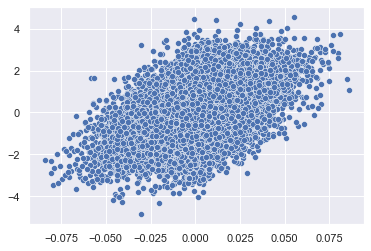

In [647]:
plt1 = sns.scatterplot(int_pred.flatten(), exp_pred.flatten())

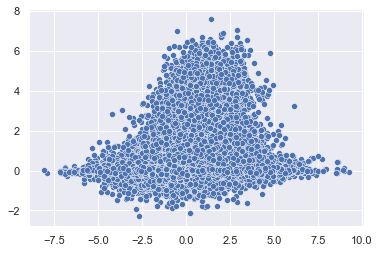

In [648]:
plt2 = sns.scatterplot(int0_pred.flatten(), exp0_pred.flatten())

The non-zero-filled plot shows a slight positive correlation between interaction ratings and explicit ratings, meaning
that they somewhat agree in predictions (although not in magnitude). The zero filled data does not appear to correlate,
however this could be simply because of a high number of missing explicit ratings, which stretches the X range out.

### 1c) From predictions to recommendations (without capacity constraints)

<font color='blue'> Fill in the following function that takes in the matrix predicted ratings for each user and item, returns a dictionary where the keys are the user indices and the values are a list of length "number_top_items" indicating the recommendations given to that user

In [649]:
def get_recommendations_for_each_user(predictions, number_top_items = 10):

    recommend_dict = {}
    for user in range(len(predictions)):
        item_rating_row = predictions[user]
        sorted_items = np.argsort(np.negative(item_rating_row)).astype(int).tolist()
        # top_item_ratings = predictions[user, sorted_items[0:11]]
        recommend_dict[np.str(user)] = sorted_items[0:number_top_items]

    return recommend_dict

<font color='blue'> Output the recommendations for the first user, using each of the 4 data types

In [650]:
rec_exp = get_recommendations_for_each_user(exp_pred)
rec_exp0 = get_recommendations_for_each_user(exp0_pred)
rec_int = get_recommendations_for_each_user(int_pred)
rec_int0 = get_recommendations_for_each_user(int0_pred)
print(rec_exp['0'])
print(rec_exp0['0'])
print(rec_int['0'])
print(rec_int0['0'])

[30, 164, 121, 87, 199, 116, 108, 124, 5, 93]
[57, 55, 56, 81, 50, 78, 58, 86, 77, 96]
[74, 164, 199, 30, 73, 104, 100, 19, 198, 182]
[166, 53, 1, 111, 170, 74, 182, 37, 73, 52]


<font color='blue'> Fill in the following function that takes in the recommendations for each user and item, and outputs a histogram for how often each item is to be recommended. For example, if there are 18 items, and 10 of them were never recommended, 5 of them were recommended once each, and 3 of them were recommended five times each, then you would have bars at 0, 1, and 5, of height 10, 5, and 3, respectively.

In [651]:
def show_frequency_histograms(recommendations):
    sns.histplot(recommendations, discrete=True)

<font color='blue'> Show the histograms for the "interact" and "explicit" data types. Describe what you observe in no more than 3 sentences. For example, discuss how often is the most recommended item recommended, how that compares to the least recommended items, and what that could mean for recommendations in various contexts. 

<AxesSubplot:ylabel='Count'>

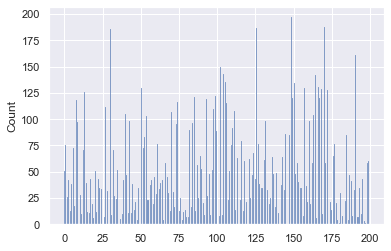

In [652]:
flat_rec_exp = sum(list(rec_exp.values()), [])
sns.histplot(flat_rec_exp, bins = 300)

<AxesSubplot:ylabel='Count'>

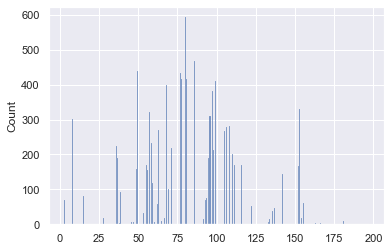

In [653]:
flat_rec_exp0 = sum(list(rec_exp0.values()), [])
sns.histplot(flat_rec_exp0, bins = 300)

<AxesSubplot:ylabel='Count'>

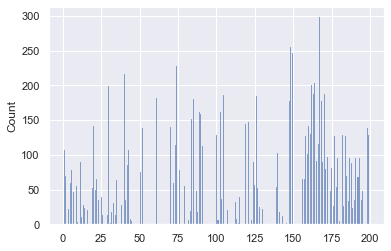

In [654]:
flat_rec_int = sum(list(rec_int.values()), [])
sns.histplot(flat_rec_int, bins = 300)

<AxesSubplot:ylabel='Count'>

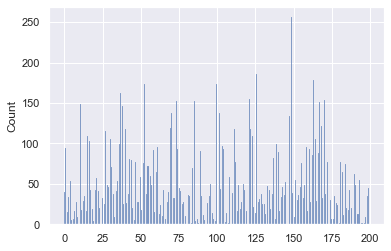

In [655]:
flat_rec_int0 = sum(list(rec_int0.values()), [])
sns.histplot(flat_rec_int0, bins = 300)

Off first glance, the explicit0 recommendations are the most skewed. The most recommended item has a frequency of
about 600, with many items never being recommended. The explicit recommendations are actually quite uniform, reaching
a maximum of about 200, with most items being recommended at least once. The interaction recommendations are quite skewed
as well, with many items never being recommended. The interaction0 is somewhere between explicit and interaction. It appears
that tracking which items don't get rated at all or don't get interacted with improves our measure of unobserved ratings,
which differentiates better the good or bad items. So, if we track non-ratings, it could give us a more differentiable
recommendation system. Of course, this means that some items never get sold, which is a bad thing itself.

# Problem 2: Cold start -- recommendations for new users

In this part of the assignment, we are going to ask you to tackle the "cold-start" problem with matrix-factorization based recommendation systems. The above recommendation techniques worked when you had access to past data for reach user, such as interactions or explicit ratings. However, it doesn't work as well when a new user has just joined the platform and so the platform doesn't have any data.  

You should also see a comma-separated values file (user_demographics.csv) that contains basic demographic information on each user. Each row describes one user, and have four attributes: 'User ID', 'Wealth', 'Age group' and 'Location'.

User ID is the unique identifier associated with each user, and it is in the same order as the user_vectors, and in the same indexing as the ratings (be careful about 0 and 1 indexing in Python).

Wealth is a non-negative, normalized value indicating the average wealth of the neighborhood in which the user is, where we normalized it such that each Location has similar wealth distributions. Age group describes the age of the user. Location describes the region that the user is from.

In [656]:
demographics = pd.read_csv("data/user_demographics.csv")
demographics.head()

,User ID,Wealth,Age group,Location
0,1,1.833101,50 to 64,America
1,2,2.194996,18 to 34,America
2,3,2.216195,18 to 34,Europe
3,4,0.838690,50 to 64,Asia Pacific
4,5,2.109313,18 to 34,America


We are now going to pretend that we don't have the personalized ratings/interactions history for the last 100 users, and thus don't have their user vectors. Rather, let's pretend that these are new users to the platform, and you are able to get the above demographics from their browser cookies/IP address. Now, we're going to try to recommend items for them anyway. For this part, we'll exclusively use the "ratings with interaction0" data.

In [657]:
existing_user_vectors = user_vectors_interact0[0:900,:]
existing_user_demographics = demographics.iloc[0:900,:]
new_user_demographics = demographics.iloc[900:,:]

### 2a) Predictions for new users [Simple]

<font color='blue'> Fill in the following function that takes in: the demographics of a single new user, the demographics of all the existing users in your platform, and the user vectors of all the existing users, and outputs a 'predicted' user vector for the new user to use until we get enough data for that user. 
    
<font color='blue'> For this question, we ask you to use the following simple method to construct the vector for the new user. Each user is classified as "Low" or "High" wealth based on whether their Wealth score is below or above the median of 1.70. Then, we simply construct a mean user vector for "Low" and "High" wealth, based on the 900 users (take the average vector among users with "Low" and "High" Wealth, respectively.). The correpsonding mean vector is then used for each new user. 

In [658]:
existing_user_demographics.Wealth.median()

1.7026180771992308

In [659]:
def get_user_vector_for_new_user(new_user, existing_user_demographics, existing_user_vectors):
    if new_user.Wealth >= 1.7:
        high = existing_user_demographics[existing_user_demographics.Wealth >= 1.7]
        vector_indices = high['User ID']-1
        high_vectors = existing_user_vectors[vector_indices]
        user_vector = np.mean(high_vectors, axis=0)
        return user_vector
    else:
        low = existing_user_demographics[existing_user_demographics.Wealth < 1.7]
        vector_indices = low['User ID']-1
        low_vectors = existing_user_vectors[vector_indices]
        user_vector = np.mean(low_vectors, axis=0)
        return user_vector

<font color='blue'> Output the mean vector predicted for the first user in `new_user_demographics`. 

In [660]:
get_user_vector_for_new_user(new_user_demographics.iloc[0], existing_user_demographics, existing_user_vectors)

array([ 0.0883247 , -0.21070289, -0.17663823, -0.13147576, -0.08988904,
       -0.1261695 , -0.12226663, -0.42640732, -0.05810349, -0.10786069])

### 2b) [Bonus, 3 points] Predictions for new users [Using KNN or another model]

<font color='blue'> Fill in the following function that takes in: the demographics of a single new user, the demographics of all the existing users in your platform, and the user vectors of all the existing users, and outputs a 'predicted' user vector for the new user to use until we get enough data for that user. 
    
<font color='blue'> Now, use K nearest neighbors or some other machine learning method. 
    
<font color='blue'> Feel free to prepare data/train a model outside this function, and then use your trained model within the function.

In [661]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor

In [662]:
new_user_e = pd.get_dummies(new_user_demographics)
cols = new_user_e.columns.to_list()
new_user_e = StandardScaler().fit_transform(new_user_e)
new_user_e = pd.DataFrame(new_user_e, columns=cols)

new_user = new_user_e.drop('User ID', axis=1).iloc[0]
new_user.to_numpy().reshape(1, -1)

array([[-1.51511666, -0.81649658,  1.68705478, -0.67028006, -0.17586311,
        -0.10050378,  1.1055416 , -0.45256964, -0.76635604]])

In [663]:
def get_user_vector_for_new_user_knn(new_user, existing_user_demographics, existing_user_vectors):

    # Processing X_train
    existing_demo_e = pd.get_dummies(existing_user_demographics)
    cols = existing_demo_e.columns.to_list()
    existing_demo_e = StandardScaler().fit_transform(existing_demo_e)
    existing_demo_e = pd.DataFrame(existing_demo_e, columns=cols)

    # Processing Y_train
    user_vectors_df = pd.DataFrame(existing_user_vectors)

    # Converting new user vector to 2D array
    X_pred = new_user.to_numpy().reshape(1, -1)

    # Training
    KNN_user = KNeighborsRegressor(n_neighbors=9, weights='distance')
    multi_KNN = MultiOutputRegressor(KNN_user)
    multi_KNN.fit(existing_demo_e.drop('User ID', axis=1), user_vectors_df)

    # Predict
    return multi_KNN.predict(X_pred)

<font color='blue'> Output the mean vector predicted for the first user in `new_user_demographics`. 

In [664]:
get_user_vector_for_new_user_knn(new_user, existing_user_demographics, existing_user_vectors)

array([[ 0.52425168, -0.42623685, -0.26308299, -0.08052444,  0.02276924,
        -0.2187127 , -0.27354197, -0.80017443, -0.53780436, -0.36254291]])

<font color='blue'> Justify your choice of model. If you used K nearest neighbors, then how did you decide upon your distance function? If you used another model, how does that model weight the different demographics in importance (either implicitly or explicitly)?

I used inverse distance. This is because there's a decently high number of features after one-hot-encoding and I want
to avoid overfitting. I used K=9 as a bit of a rule of thumb. I could use cross validation to experiment but that would
be a lot more code.

### 2c) Comparing predictions from "true" user vector and from above

<font color='blue'> For each of the 100 "new" users, use either your model from 2a or 2b ("demographic model") to retrieve a user vector for that user, and then your functions from Problem 1 to get predicted ratings and top-10 recommendations. First, plot a scatterplot between the ratings predicted by the demographic model and the ratings predicted by the full model from Problem 1. Each point in the scatter plot should correspond to one user and one item, and so your scatterplot should have 100*200 points.  

In [665]:
new_user_vectors = np.zeros([0,10])
for index, user_demographic in new_user_e.iterrows():
    user = new_user_e.drop('User ID', axis=1).iloc[index]
    new_vector = get_user_vector_for_new_user_knn(user, existing_user_demographics, existing_user_vectors)
    new_user_vectors = np.append(new_user_vectors, new_vector, axis=0)

In [666]:
KNN_matrix = get_predictions(new_user_vectors, book_vectors_interact0)
actual_matrix = get_predictions(user_vectors_interact0[900:,:], book_vectors_interact0)
# print(np.shape(KNN_matrix))
# print(np.shape(actual_matrix))

[(-7.5, 9.0)]

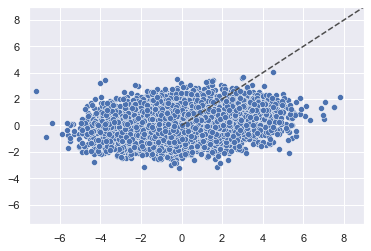

In [667]:
plt1 = sns.scatterplot(actual_matrix.flatten(), KNN_matrix.flatten())
# plt1.set_aspect('equal')
plt.plot([0, 10], [0, 10], ls="--", c=".3")
plt1.set(xlim = [-7.5, 9])
plt1.set(ylim = [-7.5, 9])

<font color='blue'> Now for each user, calculate the mean rating (according to the "full" model in Problem 1) for the 10 items recommended to that user, by each of the demopgraphic and "full" models. Output a scatterplot for the two mean ratings, where each point correpsonds to 1 user.

In [668]:
recommended_actual = get_recommendations_for_each_user(actual_matrix, number_top_items = 10)
recommended_KNN = get_recommendations_for_each_user(KNN_matrix, number_top_items = 10)

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

actual_mean_ratings = []
for user, items in recommended_actual.items():
    rec_ratings = []
    item_ratings = list(actual_matrix[int(user),:])
    for item in items:
        rec_ratings.append(item_ratings[item])
    mean_rating = np.mean(rec_ratings)
    actual_mean_ratings.append(mean_rating)

KNN_mean_ratings = []
for user, items in recommended_KNN.items():
    rec_ratings = []
    item_ratings = list(actual_matrix[int(user),:])
    for item in items:
        rec_ratings.append(item_ratings[item])
    mean_rating = np.mean(rec_ratings)
    KNN_mean_ratings.append(mean_rating)

[(-4.0, 6.0)]

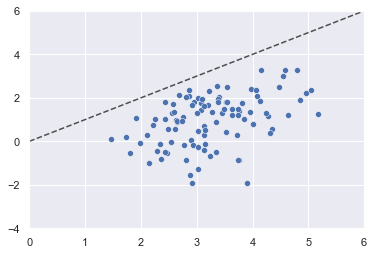

In [669]:
plt2 = sns.scatterplot(actual_mean_ratings, KNN_mean_ratings)
plt.plot([0, 10], [0, 10], ls="--", c=".3")
plt2.set(xlim = [0, 6])
plt2.set(ylim = [-4, 6])

<font color='blue'> Comment on the above. What is the "loss" from using demogprahics since we do not have access to the full data?

This scatterplot shows us that the mean recommendation ratings are on average lower with KNN prediction than with full data!
Had we made perfect predictions, the scatter would sit exactly on the black dotted line. However, in this case, it is
always lower. This means that the customers are overall less satisfied with their recommendations, a loss from not using
the full data.

# Problem 3: Predictions under capacity constraints

Above, you should have observed that if we just recommend the top items for each user, some items get recommended quite a bit, and many items do not get recommended at all. Here, we are going to ask you to implement recommendations under capacity constraints.

Throughout this part, assume that you only have 5 copies of each item that you recommend, and that you will only recommend 1 item to each user. In other words, you cannot recommend the same item more than 5 times, and so there are exactly 1000 items in stock (representing 200 unique books) for your 1000 users. 

We'll continue exclusively using the "ratings with interaction0" data.

Now, let's assume that users are entering the platform sequentially in order of index. So the index 0 user comes first, index 1 user comes second, etc. 

### 3a) Naive recommendations under capacity constraints

<font color='blue'> First, let's pretend that we were naively recommending the predicted favorite item to each user. Of course, with unlimited capacity, each user would be recommended their predicted favorite. With capacity constraints, the favorite items of the users who come in later might already have reached their capacity, and so they have to be recommended an item further down their list. 
    
<font color='blue'> Do the following: simulate users coming in sequentially, in order of index. For each user, recommend to them their predicted favorite item that is still available. So the first user will get their favorite item, but the last few users will almost certainly not receive any of their top few predicted items. For each user, keep track of what the rank of the item that they were ultimately recommended was, according to the predicting ranking over items for that user.
    
<font color='blue'> Plot the resulting rankings in 2 ways: 1) A line plot, where the X axis is the user index and the Y axis is the rank of the item that they were recommended. and 2) A histogram of how often each rank shows up. (the X axis is the (binned) rank, and the Y axis is the count of that bin). 

In [670]:
stock = np.zeros([200])
stock.fill(5)
ranks = np.zeros([1000])

In [671]:
rec_int0_2 = get_recommendations_for_each_user(int0_pred, number_top_items=200)

In [672]:
for user, items in rec_int0_2.items():
    rank = 1
    for item in items:
        if stock[item] != 0:
            stock[item] -= 1
            ranks[int(user)] = rank
            break
        else:
            rank += 1

# ranks[ranks == 0] = 11


<AxesSubplot:>

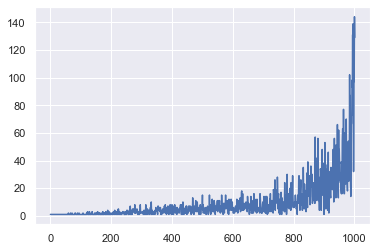

In [673]:
sns.lineplot(np.linspace(1,1001,1000), ranks)

<AxesSubplot:ylabel='Count'>

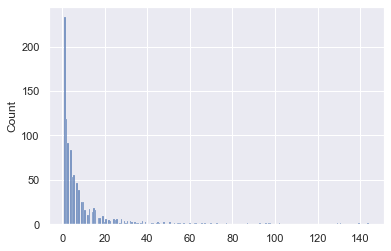

In [674]:
sns.histplot(ranks,bins=200)

We can see a strong upward trend, as expected. However, note that many users are recommended even their > 100 ranked item, while
many others are able to get their top 1 item. Clearly, this is not optimized for the overall optimum. The histogram shows
exactly how lopsided this is.

### 3b) [Bonus -- 6 pts] Optimal recommendations under capacity constraints -- maximum weight matching

[3 points] <font color='blue'> Now let's do "optimal" recommendations with capacity, using maximum weight matching. Create the same two plots as above. <font color='blue'> Describe what you observe compared to the naive recommendations above. 
    
<font color='blue'>We suggest you use the `scipy.optimize.linear_sum_assignment` function. In that case, `np.tile` might also come in handy to create 5 copies of each items.  

In [675]:
C = np.zeros([1000,200])

for user, items in rec_int0_2.items():
    rank = 1
    for item in items:
        weight = int0_pred[int(user),item]
        C[int(user),item] = rank
        rank += 1

In [676]:
tiled_matrix = np.tile(int0_pred, (1,5))

In [677]:
from scipy.optimize import linear_sum_assignment

In [678]:
optimum = pd.DataFrame(linear_sum_assignment(tiled_matrix, maximize=True))

In [679]:
ranks2 = np.zeros(1000)

for user, content in optimum.items():
    item = content[1] - np.floor(content[1]/200) * 200
    rank = C[int(user), int(item)]
    ranks2[user] = rank

<AxesSubplot:xlabel='0'>

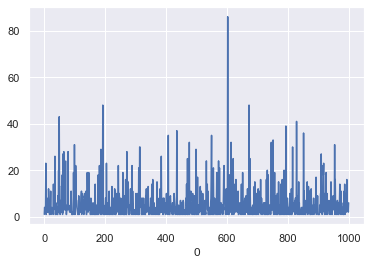

In [680]:
sns.lineplot(optimum.iloc[0],ranks2)

<AxesSubplot:ylabel='Count'>

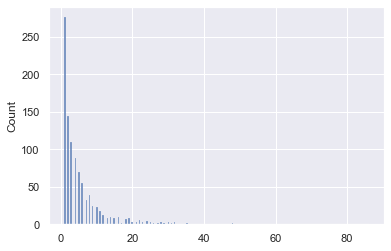

In [681]:
sns.histplot(ranks2,bins=200)

This appears far more optimized. The histogram has improved, with more recommendations that are highly ranked. There is
also a lack of very poorly ranked recommendations.
The scatter shows that the allocation is much more fair.

[3 points] <font color='blue'> Of course, in reality you don't observe all the users at the same time -- they come in one by one, and you need to create a recommendation for the first user before the 50th user shows up. Here's let's pretend that users show up in batches of 100. So the first 100 users at the same time, next 100, etc. In this case, you can do "batched maximum weight matching," where you run maximum weight matching for the first 100 together to determine recommendations. Then, you do the same thing for the next 100 users with the items that are remaining, etc. 
    
<font color='blue'> Implement the above, show the same two plots as above, and describe what you observe. Note that this part requires careful attention for how many of each item remain after each round. 

### 3c) Score functions for recommendations under capacity constraints

<font color='blue'>Here, we are working with just 200 items and 1000 users, and so batched maximum weight matching is feasible to run. In practice, with millions of items, that  might not be an effective strategy. Now, we ask you to implement the score function approach from class.

<font color='blue'> You should normalize the predicted ratings between 0 and 1 so that you are not dividing by a negative or close to 0 average rating before proceeding.
    
<font color='blue'> Implement the above and run the same simulation as part 3c, show the same two plots, and describe what you observe.

For this part, use the following score function:
    
$$\frac{r_{ij}}{\bar{r_{ij}}} \sqrt{C_j} $$

Comment for entire homework: In this homework, we haven't been careful with what is "training" data and what is "test" data. For example, in 3c, you're using average ratings from customers who haven't shown up yet in your simulation. In Problem 2, when training the user/book vectors we used data from customers that we are then pretending we haven't seen data from. In practice, and for the class project, you should be more careful. Such train/test/validation pipelines should be a core part of what you learn in machine learning classes. 